In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
%load_ext autoreload
%autoreload 2

import pickle
import time
import tensorflow as tf
import numpy as np

from analysis import *
from spectral_adversarial_regularization.models import elunet as model

%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Xtr = mnist.train.images.reshape(-1, 28, 28, 1)
Ytr = mnist.train.labels.astype(float)

Xtt = mnist.test.images.reshape(-1, 28, 28, 1)
Ytt = mnist.test.labels.astype(float)

val_set = {'X': Xtt[:500], 'Y': Ytt[:500]}
C2 = np.mean([np.sqrt(np.sum(np.square(i))) for i in Xtr])
gamma = 0.04*C2
eps_wrm = 1./(2*gamma)

eps_wrm = 1.3 # Note the above eps_wrm is 1.3563756028, but we'll use 1.3 as used in the paper's code

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
arch = model.elunet
save_dir = os.path.join('save_weights', 'mnist', 'wrm')
train_network(Xtr, Ytr, val_set, arch, save_dir, eps=eps_wrm, adv='wrm', retrain=False)

Model already exists.. loading trained model..
INFO:tensorflow:Restoring parameters from save_weights/mnist/wrm/checkpoints/epoch200
Train acc: 1.00 (23.4 s elapsed)


In [8]:
# Estimate eps for the other samples using the perturbation achieved for each test sample
save_dir = os.path.join('save_weights', 'mnist', 'wrm')
arch = model.elunet

Xtr_adv_wrm = ad.build_graph_and_gen_adv_examples(Xtr, arch, save_dir, beta=1, num_channels=1,
                                                  load_epoch=25, method=ad.wrm, eps=eps_wrm)
    
eps = np.sqrt(np.mean([np.sum(np.square(i)) for i in Xtr_adv_wrm-Xtr])) 
print(eps/C2)

# Note: the above eps/C2 is 0.0558342058, but we'll use 0.05 as seen in Figure 2a of the paper
eps = 0.05*C2

INFO:tensorflow:Restoring parameters from save_weights/mnist/wrm/checkpoints/epoch25
0.0558342058134


In [6]:
arch = model.elunet
methods = ['erm', 'fgm', 'pgm']

for method in methods:
    save_dir = os.path.join('save_weights', 'mnist', method)
    train_network(Xtr, Ytr, val_set, arch, save_dir, eps=eps, adv=method, retrain=False)

Model already exists.. loading trained model..
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch88
Train acc: 1.00 (3.1 s elapsed)
Model already exists.. loading trained model..
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/fgm/checkpoints/epoch108
Train acc: 1.00 (3.2 s elapsed)
Model already exists.. loading trained model..
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/pgm/checkpoints/epoch35
Train acc: 1.00 (3.1 s elapsed)


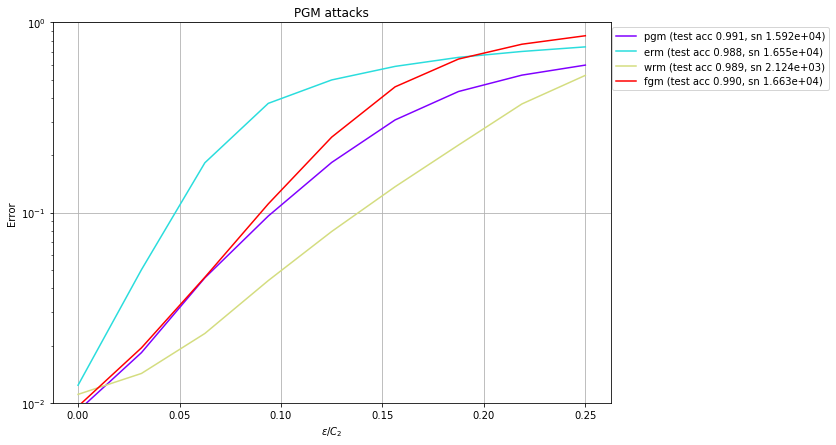

In [8]:
# Evaluate robustness of networks
eps_list = np.linspace(0, 0.25, 9)*C2
methods = ['erm', 'fgm', 'pgm', 'wrm']
curves_file = 'save_weights/mnist/adv_attack_curves_loadepoch25.pickle'

if os.path.isfile(curves_file):
    adv_results = pickle.load(file(curves_file, 'rb'))
else:
    adv_results = {}
    for method in methods:
        save_dir = os.path.join('save_weights_final', 'mnist', method)
        s_norm = dl_utils.get_overall_sn(save_dir, arch, num_channels=1, load_epoch=25)
        acc, adv_accs = get_adv_acc_curve(Xtt, Ytt, save_dir, arch, eps_list, load_epoch=25)
        adv_results[method] = (acc, adv_accs, s_norm)
    pickle.dump(adv_results, file(curves_file, 'wb'))
        
plot_acc_curves(adv_results, eps_list/C2)

INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/fgm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/fgm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/pgm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/pgm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/wrm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/wrm/checkpoints/epoch25


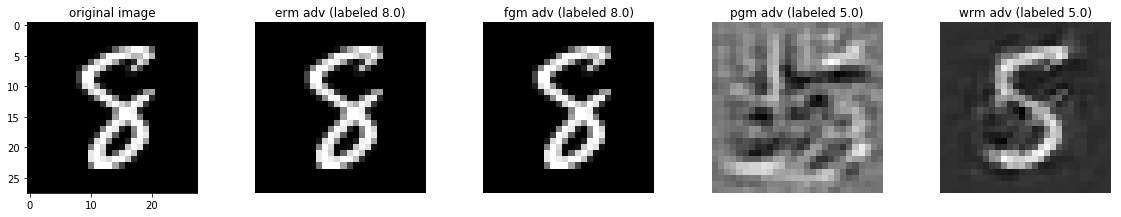

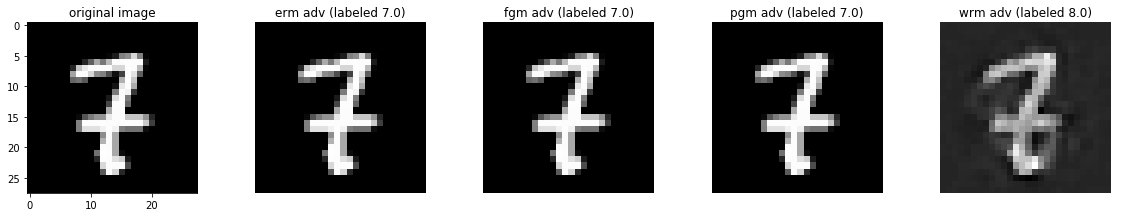

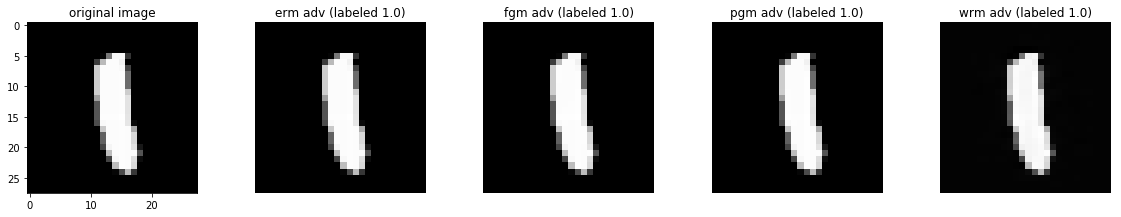

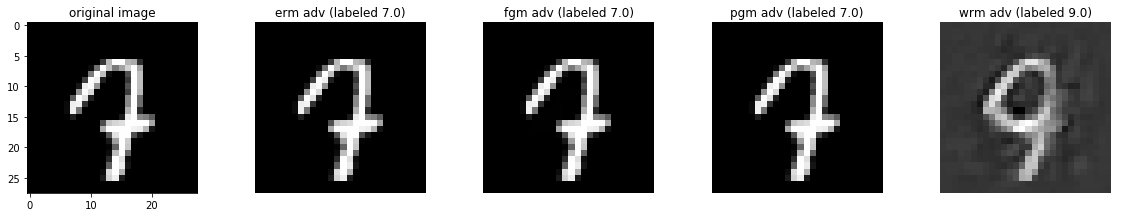

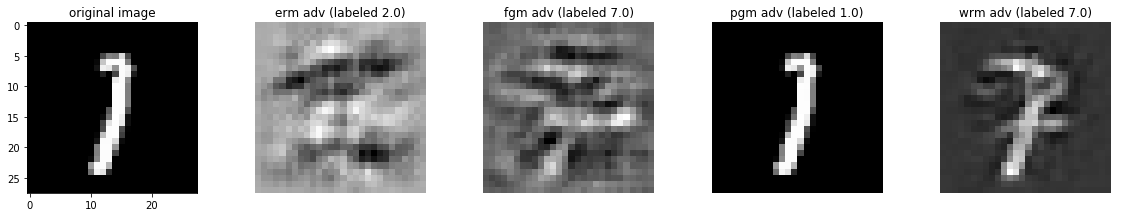

In [10]:
# Taking a closer look at some images after adversarial perturbation
eps = 0.3*C2

n = 5
np.random.seed(0)
ind_samp = np.random.choice(range(len(Xtt)), n, replace=False)
Xtt_samp = Xtt[ind_samp]

adv_examples = {}
for method in methods:
    save_dir = os.path.join('save_weights', 'mnist', method)
    X_adv = ad.build_graph_and_gen_adv_examples(Xtt_samp, arch, save_dir, num_channels=1,
                                                method=ad.wrm, eps=eps, order=2, load_epoch=25)
    Y_adv = dl_utils.build_graph_and_predict(X_adv, save_dir, arch, beta=1., num_channels=1, load_epoch=25)
    adv_examples[method] = (X_adv, Y_adv)
    
for i in range(n):
    plt.figure(figsize=(16, 3))
    plt.subplot(1, 5, 1)
    plt.imshow(Xtt_samp[i].reshape(28, 28), cmap='gray')
    plt.title('original image')
    for ii, method in enumerate(methods):
        plt.subplot(1, 5, ii+2)
        plt.imshow(adv_examples[method][0][i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title('%s adv (labeled %s)'%(method, adv_examples[method][1][i]))
    plt.tight_layout()
    plt.show()

# Testing spectral normalization

In [5]:
eps_list = np.linspace(0, 0.25, 9)*C2
methods = ['erm', 'fgm', 'pgm', 'wrm']

### Comparing all methods

In [50]:
# Estimates of final spectral norms
for method in methods:
    snorms_file = 'save_weights/mnist/%s_final_sn.pickle'%(method)
    results = get_final_sn(method, model.elunet_sn, model.elunet, load_epoch=25, snorms_file=snorms_file)
    display(snorms_to_pd_table(results).round(2)) #.to_latex()

,layers,erm,$\beta$ = 1.0,$\beta$ = 2.0,$\beta$ = 2.25,$\beta$ = 2.5,$\beta$ = 4.0,$\beta$ = 8.0
0,conv1,4.02,1.01,2.05,2.42,2.56,4.02,6.37
1,conv2,18.13,1.04,2.06,2.27,2.50,3.96,7.97
2,conv3,11.24,0.98,2.08,2.34,2.55,3.99,8.00
3,fc,1.74,1.00,2.02,2.28,2.49,2.24,1.81


,layers,fgm,$\beta$ = 1.0,$\beta$ = 2.0,$\beta$ = 2.25,$\beta$ = 2.5,$\beta$ = 4.0,$\beta$ = 8.0
0,conv1,2.95,1.00,2.00,2.24,2.57,3.98,5.06
1,conv2,28.63,1.05,2.03,2.25,2.52,4.02,8.00
2,conv3,8.91,1.08,2.11,2.30,2.51,4.00,8.00
3,fc,1.71,1.04,2.01,2.30,2.50,2.87,2.41


,layers,pgm,$\beta$ = 1.0,$\beta$ = 2.0,$\beta$ = 2.25,$\beta$ = 2.5,$\beta$ = 4.0,$\beta$ = 8.0
0,conv1,4.42,1.02,2.10,2.39,2.61,4.02,5.39
1,conv2,23.40,1.07,2.06,2.24,2.53,4.02,7.83
2,conv3,9.24,1.04,2.06,2.28,2.56,4.06,8.00
3,fc,1.58,1.02,1.98,2.26,2.49,2.13,1.62


,layers,wrm,$\beta$ = 1.0,$\beta$ = 2.0,$\beta$ = 2.25,$\beta$ = 2.5,$\beta$ = 4.0,$\beta$ = 8.0
0,conv1,2.11,1.01,2.02,2.26,2.50,3.99,3.01
1,conv2,11.20,1.00,2.02,2.25,2.49,4.01,8.00
2,conv3,4.69,1.01,1.98,2.26,2.50,4.00,4.96
3,fc,1.41,1.02,1.96,2.06,1.82,1.47,1.40


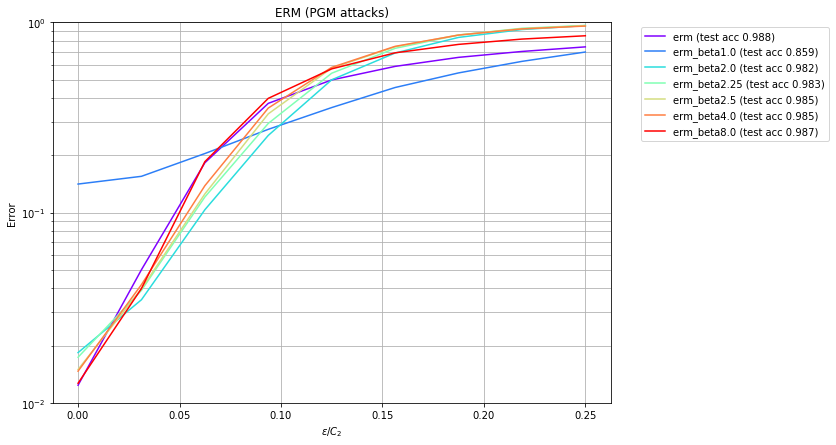

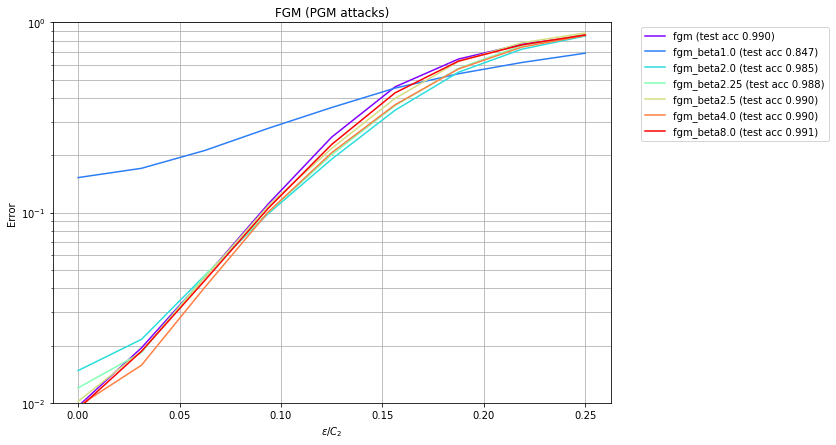

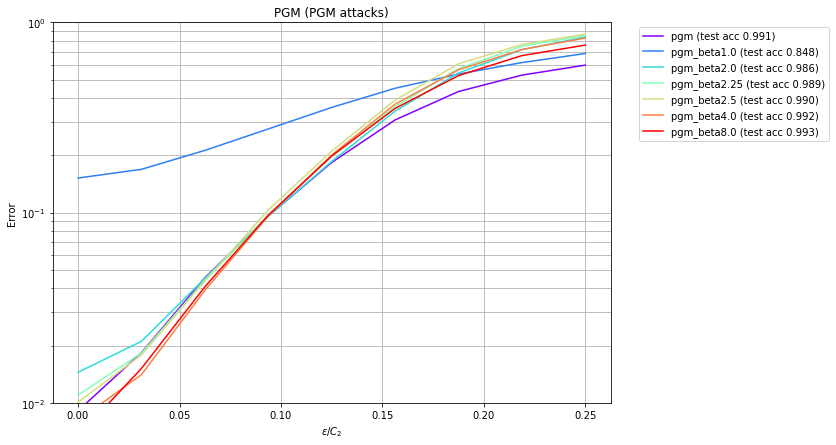

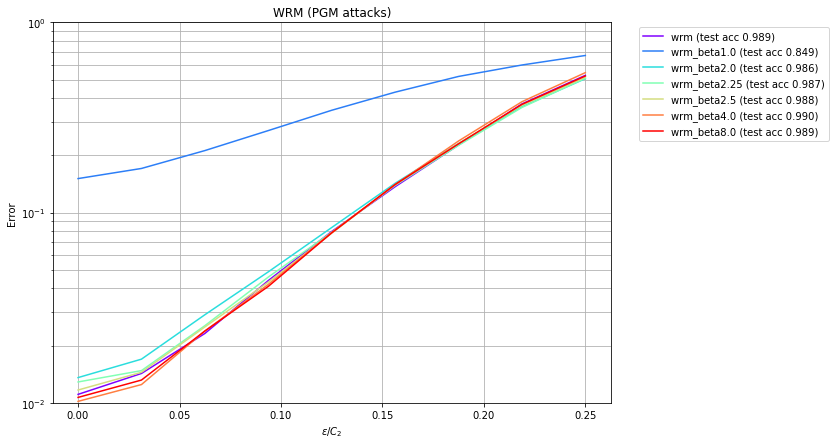

In [30]:
curves_file = 'save_weights/mnist/beta_adv_sweep_curves_loadepoch25.pickle'

if os.path.isfile(curves_file):
    all_beta_curves = pickle.load(file(curves_file, 'rb'))
else:
    all_beta_curves = {}
    
for method in methods:
    if method not in all_beta_curves:
        all_beta_curves[method] = beta_sweep_curves(Xtt, Ytt, method, eps_list, model.elunet_sn,
                                                    model.elunet, load_epoch=25)
        
    plot_acc_curves(all_beta_curves[method], eps_list/C2,
                    title='%s (PGM attacks)'%(method.upper()), sort_func=sort_func)
    
# pickle.dump(all_beta_curves, file(curves_file, 'wb'))

### WRM

In [26]:
eps_file = 'save_weights/mnist/wrm_eps.pickle'
results = get_eps_wrm(Xtr, model.elunet_sn, model.elunet, eps_wrm, load_epoch=25, eps_file=eps_file)

for k, v in sorted(results.items()):
    print('%20s with eps/C2 = %.10f'%(k, v/C2))

                 wrm with eps/C2 = 0.0558342060
         wrm_beta1.0 with eps/C2 = 0.0721508219
         wrm_beta2.0 with eps/C2 = 0.0612042067
        wrm_beta2.25 with eps/C2 = 0.0586298504
         wrm_beta2.5 with eps/C2 = 0.0574544632
         wrm_beta4.0 with eps/C2 = 0.0547897371
         wrm_beta8.0 with eps/C2 = 0.0539684452


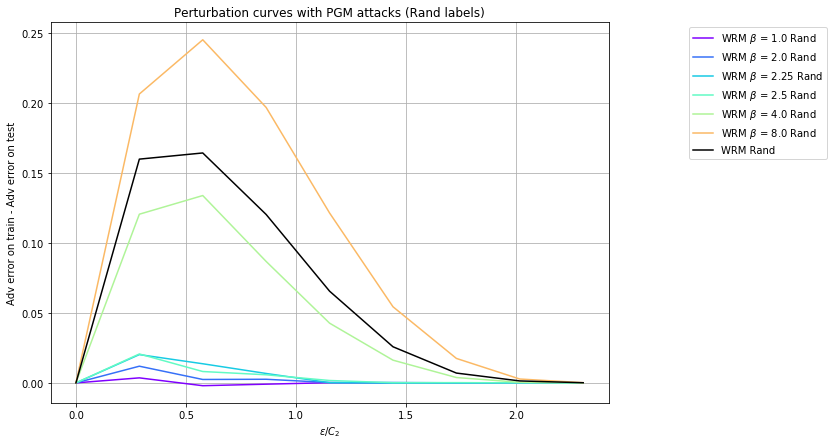

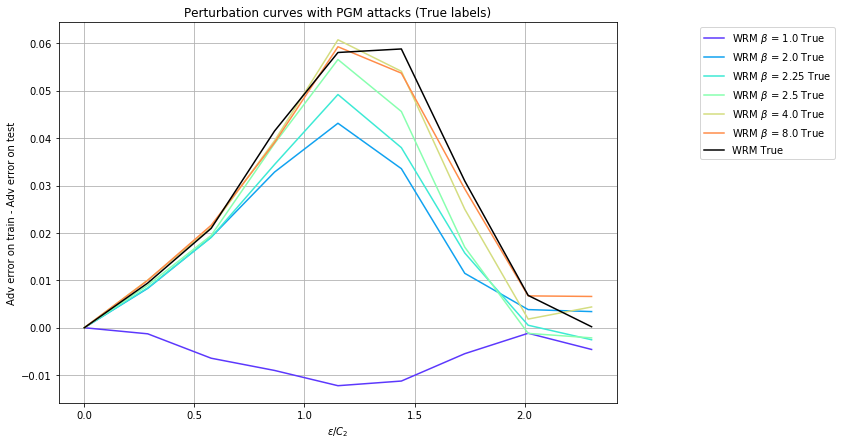

In [43]:
# Seeing how easily perturbed the network is on train v test data

# # Using true labels
# adv = 'wrm'
# curves_file = 'save_weights/mnist/%s_perturbation_curves_truelabels.pickle'%(adv)
# betas_of_interest = [0, 2.25]
# adv_results = get_train_v_test_adv_acc_curves(Xtr, Ytr, Xtt, Ytt, model.elunet_sn, model.elunet,
#                                               adv, eps_list, load_epoch=25, curves_file=curves_file,
#                                               betas_of_interest=betas_of_interest)
# plot_perturbation_curves(eps_list, adv_results)

adv = 'wrm'
curves_file = 'save_weights/mnist/%s_perturbation_curves.pickle'%(adv)
adv_results = get_perturbation_curves(Xtr, Xtt, model.elunet_sn, model.elunet, adv,
                                      eps_list, load_epoch=25, curves_file=curves_file, 
                                      maindir='save_weights/mnist/')

plot_perturbation_curves(eps_list, adv_results)

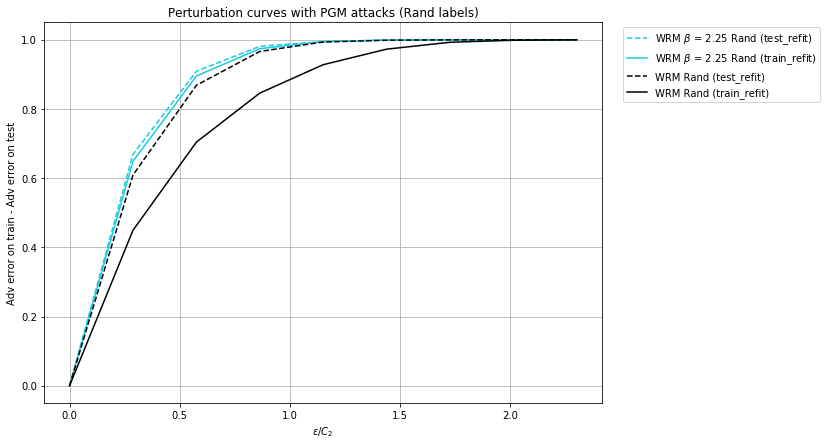

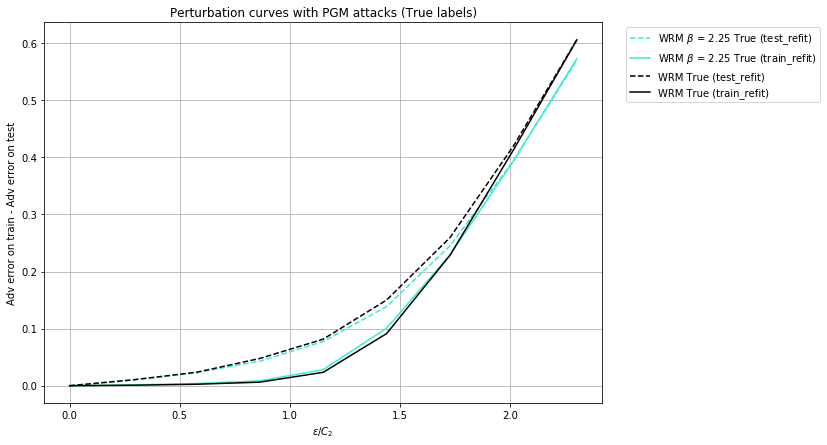

In [66]:
beta_list = [0, 2.25]
plot_perturbation_curves(eps_list, adv_results, mode=2, betas_of_interest=beta_list)

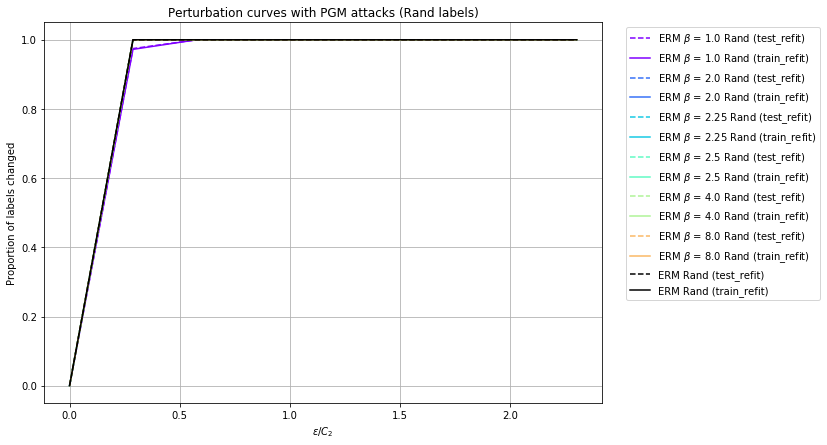

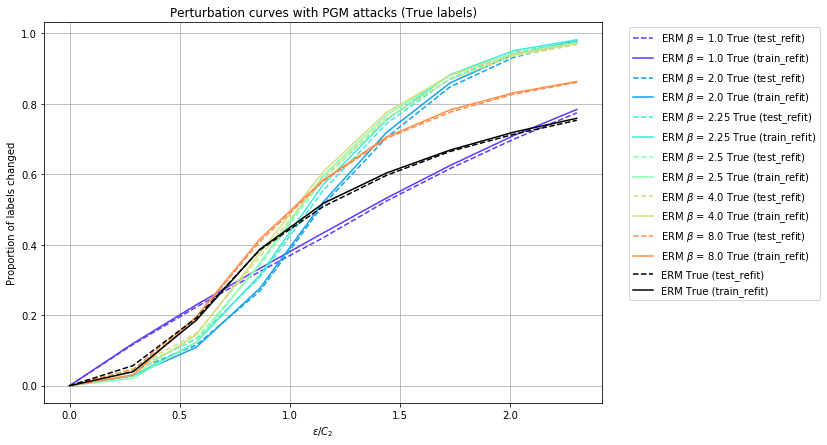

In [98]:
adv = 'erm'
curves_file = 'save_weights/mnist/%s_perturbation_curves.pickle'%(adv)
adv_results = get_perturbation_curves(Xtr, Xtt, model.elunet_sn, model.elunet, adv,
                                      eps_list, load_epoch=25, curves_file=curves_file, 
                                      maindir='save_weights/mnist/')

plot_perturbation_curves(eps_list, adv_results, mode=2)